### Prediction Using the Multi input Recurrent NN 

* Creation of the RNN is done in [Multi_Input3RNN_Perfect_Creation](Multi_Input3RNN_Perfect_Creation.ipynb)
* Training of the RNN is done in  [Multi_Input3RNN_Perfect_Training](Multi_Input3RNN_Perfect_Training.ipynb)


---

In [1]:
def scale_Rnn_inputs(scaler_dict, rnn_input_dict, inverse=False):
    """ 
    Scale or unscale all the inputs input in rnn_input_dict
    
Parameters:
-----------
rnnInput_dict: dict
    Non scaled input of the Electrical network:
fitting_scaler_dict: Scaler
    Scaler parameters dict that are used to transform the input_dict data 
    fed to the RNN. 
inverse:bool
    Whether to scale or to unscal the rnn_input dict

    """
    if inverse: # rnn_input_dict must be unscaled scaled 
        rnn_input_dict
        
        unscaled_num = scaler_dict['numerical_scaler'].inverse_transform(rnn_input_dict['num'])
        unscaled_num_Vrise = scaler_dict['numerical_Vrise_scaler'].inverse_transform(rnn_input_dict['numVrise'])
        
        return unscaled_num, unscaled_num_Vrise
        
    else: # rnn_input_dict must be scaled  
        # Transform (i.e. scaled ) training following the fitting previously donne
        test_scaled_num = scaler_dict['numerical_scaler'].transform(rnn_input_dict['num'])
        test_scaled_cycle = scaler_dict['numerical_scaler_cycle'].transform(rnn_input_dict['numCycle'])
        test_scaled_num_Vrise = scaler_dict['numerical_Vrise_scaler'].transform(rnn_input_dict['numVrise'])
        test_scaled_bin_Vrise = scaler_dict['bin_Vrise_scaler'] .transform(rnn_input_dict['binVrise'])

        # Reshape scaled data
        test_scaled_num = np.expand_dims(test_scaled_num, axis=0)
        test_scaled_cycle = np.expand_dims(test_scaled_cycle, axis=0)
        test_scaled_num_Vrise = np.expand_dims(test_scaled_num_Vrise, axis=0)
        test_scaled_bin_Vrise = np.expand_dims(test_scaled_bin_Vrise, axis=0)

        return test_scaled_num, test_scaled_cycle, test_scaled_num_Vrise, test_scaled_bin_Vrise



def multiInputRnn_predict(rnn_model, rnnInput_dict, fitting_scaler_dict):
    """
Prediction bloc: Predict the output: 
    (1) ['Cons', 'Prod_BT', 'P0013', 'P0018', 'P0100']
    (2) [Binary voltage rise]
    (3) [numerical voltage rise]
of the next timestep

Prameters: 
----------
rnn_model: Recurent neural network; 
    The MultiInput RecurentNN
rnnInput_dict: Non scaled input of the Electrical network:
fitting_scaler_dict: Scaler
    Scaler parameters dict that are used to transform the input_dict data 
    fed to the RNN. 
    
    """
    
    history_last_ind = rnnInput_dict['num'].index[-1] # Get index of the last period of history
    
    # Scaled the input  based on the fitting scaler 
    scaled_inputs_data = scale_Rnn_inputs(fitting_scaler_dict, rnnInput_dict)
    
    # prediction ---- note that prob_Vrise_pred is the probability that an voltage rise above the 
    # defined threshold occurs
    num_pred, prob_Vrise_pred, numVrise_pred = rnn_model.predict(scaled_inputs_data, verbose=False) 
    
    # Transform the predited values in dataframe that will be used fo upscaling (otherwise when the 
    # values are given directly without putting them in a dataframe with the associated colums name, 
    # it raises a warning during the unscaling)
    num_pred=pd.DataFrame(num_pred, 
                            columns=fitting_scaler_dict['numerical_scaler'].get_feature_names_out() 
                           )  
    num_vrise=pd.DataFrame(numVrise_pred, 
                             columns=fitting_scaler_dict['numerical_Vrise_scaler'].get_feature_names_out()
                            )
    
    # Defined a dict for predicted values to unscaled
    # The prob_Vrise_pred does not need to be unscaled since its values is a probability
    pred_to_unscaled_dict = {'num': num_pred,
                            'numVrise': num_vrise }
    # Unscaling
    num_pred, numVrise_pred = scale_Rnn_inputs(fitting_scaler_dict, pred_to_unscaled_dict, inverse=True)


    return num_pred.reshape(-1), prob_Vrise_pred.reshape(-1), numVrise_pred.reshape(-1), history_last_ind+1


---

In [2]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [4]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list, train_split_date, trainVal_split_date

In [5]:
# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
# h_start_end = ('07:00','18:50')
df_data2 = joblib.load(network_folder+'cleanedData.pkl')

h_start_end = ('06:00','19:50')

per_daylight = ( pd.Series(index=df_data2.index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

df_data2 = df_data2.loc[per_daylight]
df_data2 = df_data2[(df_data2.index>trainVal_split_date)& (df_data2.index<='2022 06 02')]



df_data = df_data2.copy(deep=True)
df_data['Month'] = df_data.index.month
df_data['Days'] = df_data.index.day_of_week
df_data['hour'] = df_data.index.hour
df_data['Minutes'] = df_data.index.minute

Δt_minutes = 60*Δt  # Sampling frequency in minutes
freq_minutes = df_data.Minutes.max()+Δt_minutes
freq_day = (len(df_data[(df_data.index>='2021 01 01') & (df_data.index<='2021 01 02')])-1)*Δt_minutes
freq_week = (len(df_data[(df_data.index>='2021 01 01') & (df_data.index<='2021 01 08')])-1)*Δt_minutes
freq_year =  len(df_data[(df_data.index>='2021 01 01') & (df_data.index<='2022 01 01')])*Δt_minutes


# Create Cycling data 
hourly_cycle = np.cos((df_data.Minutes)*2*np.pi/freq_minutes)
daily_cycle =  np.cos((60*df_data.hour+df_data.Minutes)*2*np.pi/freq_day)
weekly_cycle = np.cos((freq_day*df_data.Days + 60*df_data.hour + df_data.Minutes)*2*np.pi/freq_week)
yearly_cycle = np.cos((freq_day*df_data.index.day_of_year+ 60*df_data.hour + df_data.Minutes)*2*np.pi/freq_year)

# Create a dict for the cycling data
cycle_datadict = {name: elm.values for name, elm in zip(['hourly_cycle', 'daily_cycle', 'weekly_cycle', 'yearly_cycle'],
                                                        [hourly_cycle,daily_cycle,weekly_cycle,yearly_cycle])}
df_cycleData = pd.DataFrame(data=cycle_datadict, index=df_data.index) # Transform the cycling data into a dataframe


# # Separate training and validation set  for botht he cycling and the normal data
df_test = df_data
df_test_cycle = df_cycleData

#### Plot data

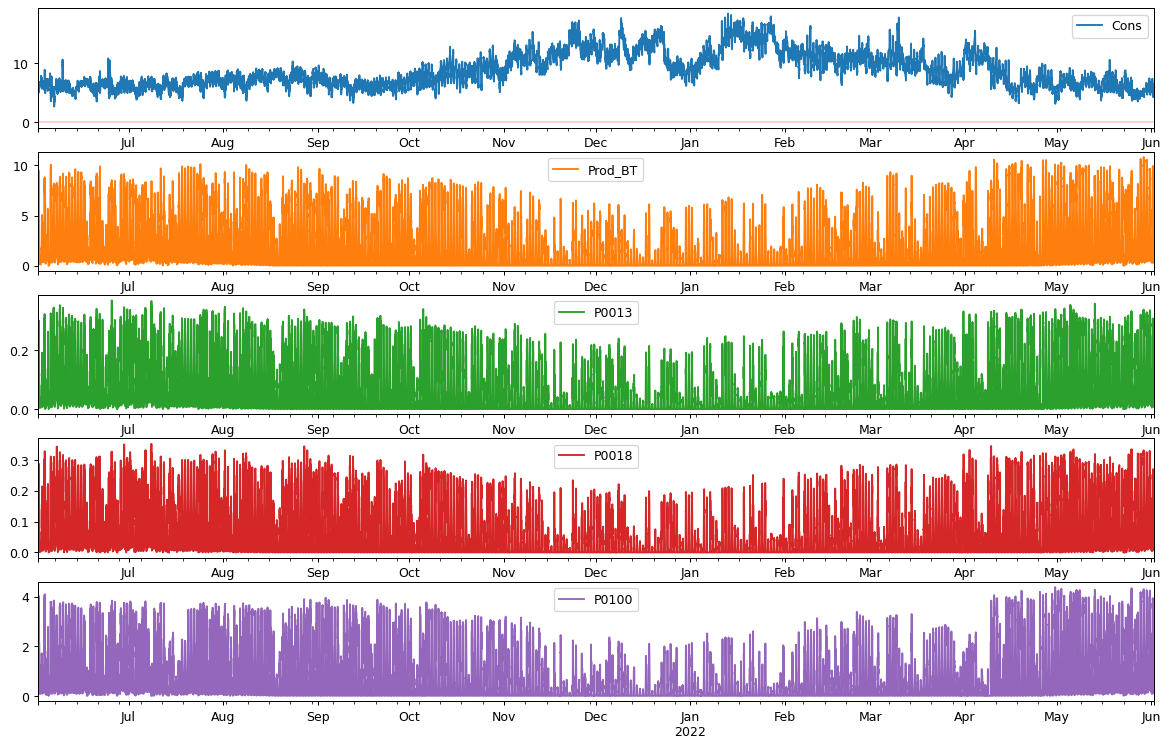

In [6]:
fig, axx = plt.subplots(5,figsize=(16,10),dpi=90)
df_test.iloc[:,:5].plot(subplots=True,ax=axx);
axx[0].axhline(0, color='red', lw=0.3)

#### Import and separate numeric voltage rise from binary voltage rise

In [7]:
df_vrise = joblib.load('pickle_files/simulationResults/Binary_Voltage_Rise.pkl')

# Extract test set period
df_test_vrise = df_vrise[(df_vrise.index> trainVal_split_date)&(df_vrise.index<='2022 06 02')]

df_test_bin_Vrise = df_test_vrise[['Volt_Rise_Bin']]
df_test_num_Vrise = df_test_vrise[['known']]

#### Import data from [Multi_Input3RNN_Perfect_Training](Multi_Input3RNN_Perfect_Training.ipynb)

##### -- Trained Recurent Neural Network

In [8]:
mixedinput_model = tf.keras.models.load_model("pickle_files/RNN/MultiInput3_perfect")

##### -- Scaler to scale traning data 

In [9]:
scaler_dict = joblib.load('pickle_files/RNN/StLaurent_MultiInput3_Scaler.plk')

#### Define time step for each inputs

<span style='color:red'> Make sure that the parameters (i.e. timestep of each inputs) defined here are the same as the one used to train the Recurrent Neural Network in [Multi_Input3RNN_Perfect_Training](Multi_Input3RNN_Perfect_Training.ipynb) </span>

In [10]:
n1_timestep = 60     # Total number of time step to consider as input            
n2_timestep = 18      # Total number of time step to consider as input
n3_timestep = 12     # Total number of time step to consider as input
n4_timestep = 12      # Total number of time step to consider as input

n1_n2_ts = n1_timestep-n2_timestep 
n1_n3_ts = n1_timestep-n3_timestep 
n1_n4_ts = n1_timestep-n4_timestep 

#### Define Rolling windows for each input

In [11]:
n_features = scaler_dict['numerical_scaler'].n_features_in_ # 'Cons', 'Prod_BT', 'P0013', 'P0018', 'P0100'

num_hist_df_test_list = list(df_test.iloc[:,:n_features].rolling(n1_timestep))
numCycle_hist_df_test_list = list(df_test_cycle.iloc[n1_n2_ts:].rolling(n2_timestep))
numVrise_hist_df_test_list = list(df_test_num_Vrise.iloc[n1_n3_ts:].rolling(n3_timestep))
binVrise_hist_df_test_list = list(df_test_bin_Vrise.iloc[n1_n4_ts:].rolling(n4_timestep))

#### Prediction 

In [292]:
len_hist = len(num_hist_df_test_list[n1_timestep:])-1

num_pred_list, prob_Vrise_list, num_vrise_list, period_list = [], [], [], []

for hist_index in tqdm(range(len_hist)):
    
    # define current hystory
    cur_hist = {'num': num_hist_df_test_list[n1_timestep+hist_index], 
                'numCycle': numCycle_hist_df_test_list[n2_timestep+hist_index], 
                'numVrise': numVrise_hist_df_test_list[n3_timestep+hist_index], 
                'binVrise': binVrise_hist_df_test_list[n4_timestep+hist_index]
               }    
    
    # run prediction for each period 
    num_pred, prob_Vrise, num_vrise, period = multiInputRnn_predict(mixedinput_model, cur_hist, scaler_dict)
    
    # Save predicted values in a list
    num_pred_list.append(num_pred)
    prob_Vrise_list.append(prob_Vrise)
    num_vrise_list.append(num_vrise)
    period_list.append(period)
    


100%|██████████| 30683/30683 [34:46<00:00, 14.71it/s]  


#### Convert predicted values into a dataframe

In [309]:
num_Vrise_pred_df = pd.DataFrame(data = np.array(num_vrise_list),
                       index=period_list,
                       columns=['numVrise'])

prob_Vrise_pred_df = pd.DataFrame(data = np.array(prob_Vrise_list),
                       index=period_list,
                       columns=['prob_Vrise'])


num_pred_df = pd.DataFrame(data = np.array(num_pred_list),
                       index=period_list,
                       columns=scaler_dict['numerical_scaler'].get_feature_names_out())

multInput_RNN_pred = pd.concat([num_pred_df, num_Vrise_pred_df, prob_Vrise_pred_df], axis=1)

In [310]:
joblib.dump(multInput_RNN_pred, "pickle_files/RNN/Multi3_Input_perfect_prediction")

['pickle_files/RNN/Multi3_Input_perfect_prediction']